## Table of Contents
1. [Import Libraries](#1)
2. [Import and Read Data](#2)
3. [Data Description](#3)
4. [Exploratory Data Analysis (EDA)](#4)\
    4.2.2 [Detect and Remove Outliers](#outlier)
5. [Data Processing](#5)
6. [Modeling](#6)
7. [Preparing for Submission](#7)

## 1. Import Libraries <a name="1"></a>

In [43]:
import warnings
warnings.filterwarnings('ignore')

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from collections import Counter

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# processing
from sklearn import preprocessing

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# machine learning
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

## 2. Import and Read Data<a name="2"></a>

In [4]:
# Download dataset from kaggle
!kaggle competitions download -c titanic

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 984kB/s]


In [5]:
# Unzip 
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [232]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["PassengerId"]

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Data Description<a name="3"></a>

Definition of the column headers are the following:

- **Survived:** 0 = Did not survive, 1 = Survived

- **Pclass:** Ticket class where 1 = First class, 2 = Second class, 3 = Third class. This can also be seen as a proxy for socio-economic status.

- **Sex:** Male or female

- **Age:** Age in years, fractional if less than 1

- **SibSp:** Number of siblings or spouses aboard the titanic

- **Parch:** Number of parents or children aboard the titanic

- **Ticket:** Passenger ticket number

- **Fare:** Passenger fare

- **Cabin:** Cabin number

- **Embarked:** Point of embarkation where C = Cherbourg, Q = Queenstown, S = Southampton

## 4. Exploratory Data Analysis (EDA)<a name="4"></a>

Analyze and visualize data to extract insights for data processing.

In [233]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 4.1 Data Types, Missing Data and Summary Statistics

In [234]:
# Identify missing data

print('total data : ' + str(len(train)))
for col in train.columns:
    none = str(round(train[col].isnull().sum()/len(train)*100, 2)) + '%'
    print(col,':', none) 

total data : 891
PassengerId : 0.0%
Survived : 0.0%
Pclass : 0.0%
Name : 0.0%
Sex : 0.0%
Age : 19.87%
SibSp : 0.0%
Parch : 0.0%
Ticket : 0.0%
Fare : 0.0%
Cabin : 77.1%
Embarked : 0.22%


Cabin has considerable amount of data missing. Missing cabin data will be analyze to determine its relationship with survivability.\
Missing data from Age and Embarked can be filled with mean and mode respectively.

In [235]:
# Summary statistics for training set

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 4.2 Feature Analysis

## 4.2.1 Categorical Variables

## Categorical Variables: Sex

In [236]:
# Value counts of the sex column

train['Sex'].value_counts(dropna = False)

# Comment: There are more male passengers than female passengers on titanic

male      577
female    314
Name: Sex, dtype: int64

In [237]:
# Mean of survival by sex

train[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 1.0, 'Survival Probability by Gender')

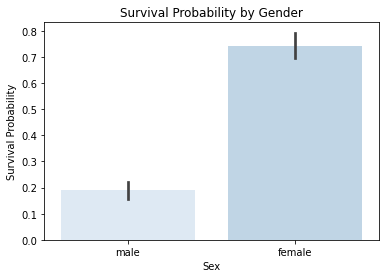

In [238]:
sns.barplot(x = 'Sex', y ='Survived', data = train, palette = sns.color_palette("Blues"))
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')

# Comment: Female passengers are more likely to survive. During the evacuation, women and children were prioritized.  

## Categorical Variables: Pclass

In [239]:
# Value counts of the Pclass column 

train['Pclass'].value_counts(dropna = False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [240]:
# Mean of survival by passenger class

train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Text(0.5, 1.0, 'Survival Probability by Passenger Class')

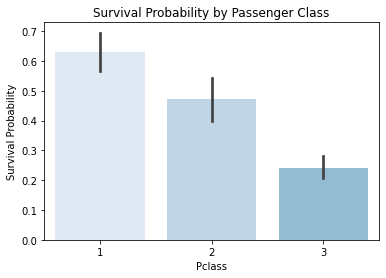

In [241]:
sns.barplot(x = 'Pclass', y ='Survived', data = train, palette = sns.color_palette("Blues"))
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')

# Comment: Survival probability decrease with passenger class, first class passengers are prioritised during evacuation

Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

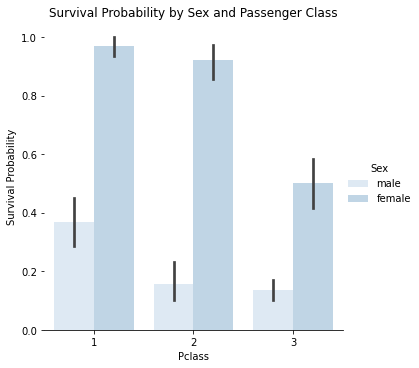

In [242]:
# Survival by gender and passenger class

g = sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar', palette = sns.color_palette("Blues"))
g.despine(left = True)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex and Passenger Class')

**Women** and **Pclass** have significantly higher survival rate than men. Women and more afluent people were prioritzed in evacuation.

## Categorical Variable: Embarked

In [243]:
# Value counts of the Embarked column 

train['Embarked'].value_counts(dropna = False)

# Comment: Two missing values in the Embarked column

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [244]:
# Mean of survival by point of embarkation

train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Text(0.5, 1.0, 'Survival Probability by Point of Embarkation')

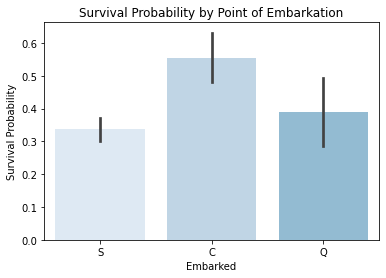

In [245]:
sns.barplot(x = 'Embarked', y ='Survived', data = train, palette = sns.color_palette("Blues"))
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Point of Embarkation')

# Comment: Passengers who embarked at C are more likely to survive. Perhaps, most of the first class passengers embarked from C.

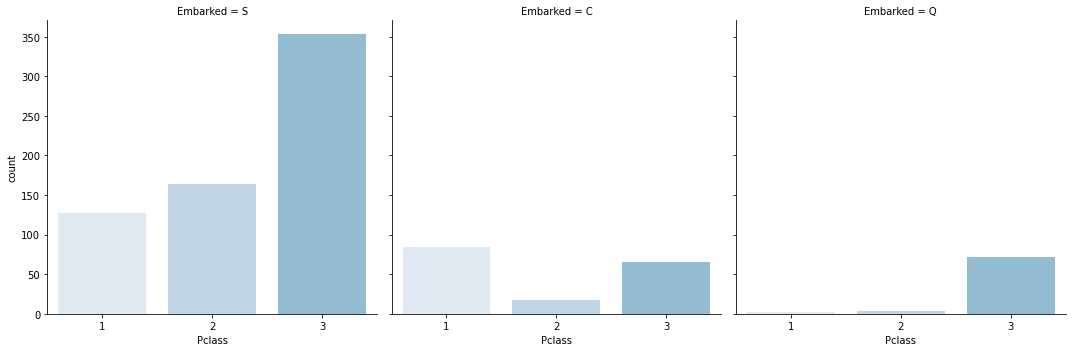

In [246]:
sns.catplot('Pclass', col = 'Embarked', data = train, kind = 'count', palette = sns.color_palette("Blues"))

# Comment: The plot delineate most of Pclass 1 passengers, who are more likely to survive, embarked from C.

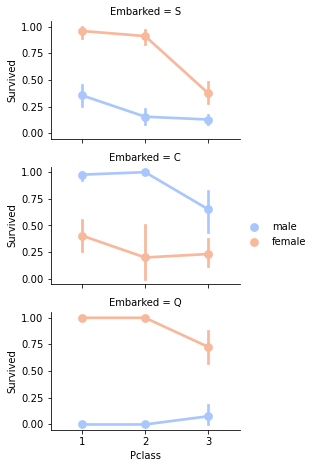

In [247]:
# Survival probability by all categorical variables

grid = sns.FacetGrid(train, row = 'Embarked', height = 2.2, aspect = 1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'coolwarm')
grid.add_legend()

# Comment: Men from C are more likely to survive than other men from other embark locations.

## 4.2.2 Numerical Variables

## Detect and Remove Outliers in Numerical Variables<a name="outlier"></a>

In [248]:
def detect_outliers(df, n, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the 
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier 
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.    
    """
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

In [249]:
outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [250]:
# Outliers in numerical variables

train.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [251]:
# Drop outliers and reset index

print("Before: {} rows".format(len(train)))
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train)))

Before: 891 rows
After: 881 rows


Removing 5% of the data is acceptable.

## Numerical Variables Correlation with Survival

<AxesSubplot:>

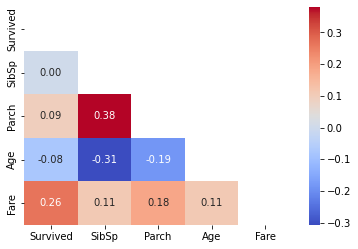

In [252]:
corr = train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm', mask = matrix)

# Comment: Fare seems to be the only feature that has a substantial correlation with survival

## Numerical variable: SibSp

In [253]:
# Value counts of the SibSp column 

train['SibSp'].value_counts(dropna = False)

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

In [254]:
# Mean of survival by SibSp

train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


Text(0.5, 1.0, 'Survival Probability by SibSp')

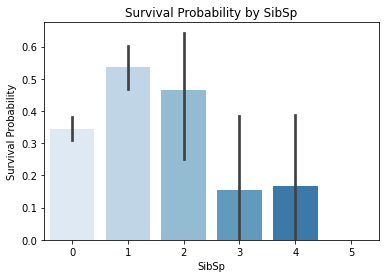

In [255]:
sns.barplot(x = 'SibSp', y ='Survived', data = train, palette = "Blues")
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

# Comment: Generally, passengers with less siblings or spouses are more likely to survive.

## Numerical variable: Parch

In [256]:
# Value counts of the Parch column 

train['Parch'].value_counts(dropna = False)

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [257]:
# Mean of survival by Parch

train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0.5, 1.0, 'Survival Probability by Parch')

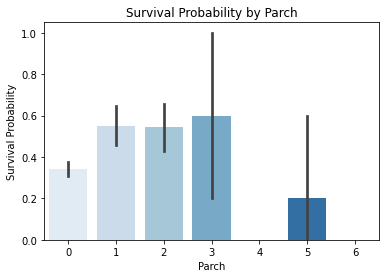

In [258]:
sns.barplot(x = 'Parch', y ='Survived', data = train, palette = "Blues")
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Parch')

# Comment: Passengers with parch between 1-3 are more likely to survive.

## Numerical variable: Age

In [259]:
# Null values in Age column 

train['Age'].isnull().sum()

170

Text(0.5, 1.0, 'Passenger Age Distribution')

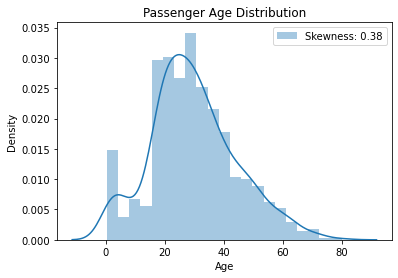

In [260]:
# Passenger age distribution

sns.distplot(train['Age'], label = 'Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

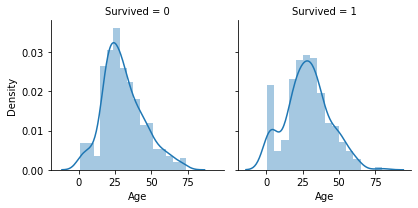

In [261]:
# Age distribution by survival

g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.distplot, 'Age')

Text(0.5, 1.0, 'Passenger Age Distribution by Survival')

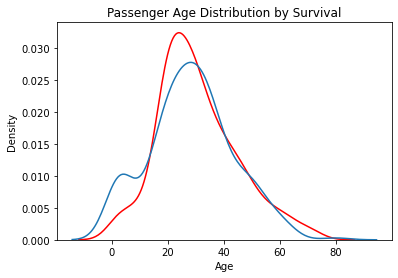

In [262]:
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Did not survive', color = "red")
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')

# Comment: The small peak on survived is indicative of the evacuation policy: women and children first.

## Numerical variable: Fare

In [263]:
# Null values of Fare column 

train['Fare'].isnull().sum()

0

Text(0, 0.5, 'Passenger Fare Distribution')

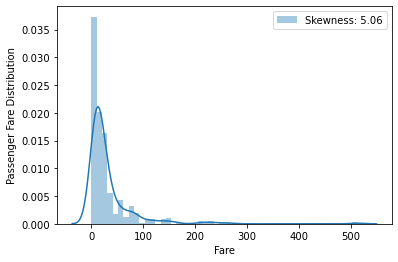

In [264]:
# Passenger fare distribution

sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

# Comment: Fare is skewed and a log transformatinon will be applied in data processing.

## 5. Data Processing<a name="5"></a>

## 5.1 Drop and Fill Missing Data

## Fill in Cabin

In [265]:
def fillna_cabin(train):
    train.Cabin.fillna(0, inplace=True)
    train.loc[train['Cabin'] != 0, 'Cabin'] = 1
    return train

In [266]:
train = fillna_cabin(train)
test = fillna_cabin(test)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


In [267]:
train['Cabin'].value_counts()

0    680
1    201
Name: Cabin, dtype: int64

In [268]:
train[['Cabin', 'Survived']].groupby('Cabin', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Cabin,Survived
1,1,0.666667
0,0,0.302941


Text(0.5, 1.0, 'Survival Probability by Cabin')

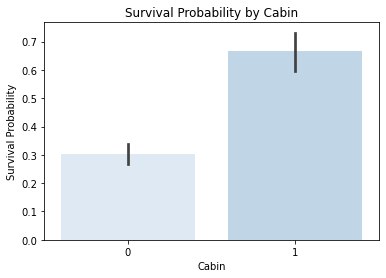

In [269]:
sns.barplot(x = 'Cabin', y ='Survived', data = train, palette = sns.color_palette("Blues"))
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Cabin')

## General Clean Up and Median/Mode Fillna

In [270]:
def clean(train):
    train = train.drop(['Ticket'], axis=1)
    train.Fare.fillna(train['Fare'].median(), inplace=True)
    train.Embarked.fillna(train['Embarked'].mode(), inplace=True)
    return train

In [271]:
train = clean(train)
test = clean(test)

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,0,S


## Fill in Age 

In [272]:
# Combine training set and test set

combine = pd.concat([train, test], axis = 0).reset_index(drop = True)

# Missing values in the combined dataset

combine.isnull().sum().sort_values(ascending = False)

Survived       418
Age            256
Embarked         2
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Cabin            0
dtype: int64

In [273]:
# Convert Sex into numerical values where 0 = male and 1 = female

combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

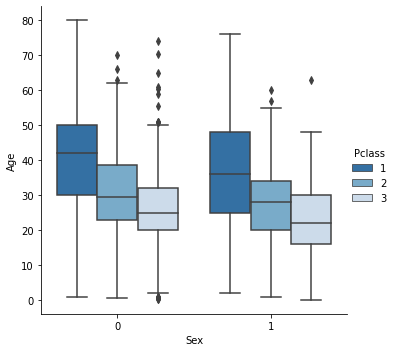

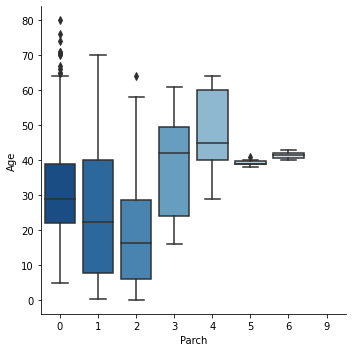

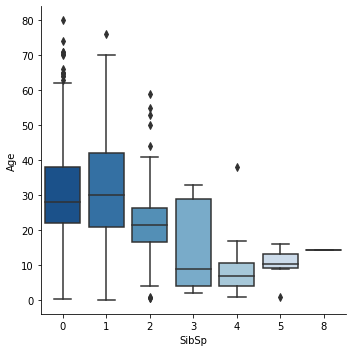

In [274]:
sns.catplot(y = 'Age', x = 'Sex', hue = 'Pclass', kind = 'box', data = combine, palette = "Blues_r")
sns.catplot(y = 'Age', x = 'Parch', kind = 'box', data = combine, palette = "Blues_r")
sns.catplot(y = 'Age', x = 'SibSp', kind = 'box', data = combine, palette = "Blues_r")

<AxesSubplot:>

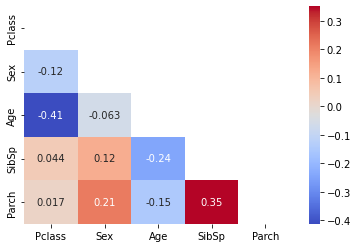

In [275]:
corr = train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(combine.drop(['Survived', 'Name', 'PassengerId', 'Fare'], axis = 1).corr(), annot = True, cmap = 'coolwarm', mask = matrix)

Age and Sex are not correlated. Age and Pclass and SibSp are negatively correlated. 

In [276]:
# Check number of missing ages 

age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

256

In [277]:
# Replace age with age with similar corresponding features.

for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp']) 
                                 & (combine['Parch'] == combine.iloc[index]['Parch'])
                                 & (combine['Pclass'] == combine.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

In [278]:
# Make sure there is no more missing ages 

combine['Age'].isnull().sum()

0

## 5.2 Data Transformation

Recall that our passenger fare column has a very high positive skewness. Therefore, we will apply a log transformation to address this issue.

Text(0.5, 1.0, 'Passenger Fare Distribution')

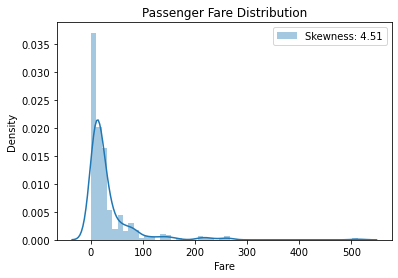

In [279]:
# Passenger fare distribution

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution')

In [280]:
# Apply log transformation to Fare column to reduce skewness

combine['Fare'] = combine['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

Text(0.5, 1.0, 'Passenger Fare Distribution After Log Transformation')

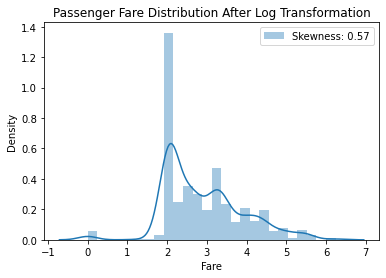

In [281]:
# Passenger fare distribution after log transformation

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution After Log Transformation')

## 5.3 Feature Engineering

## 5.3.1 Title

In [282]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1.981001,0,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4.266662,1,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,2.070022,0,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3.972177,1,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,2.085672,0,S


In [283]:
combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name','Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [284]:
combine['Title'].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [285]:
# Simplify title

combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess',
                                             'Sir', 'Dona'], 'Rare')
combine['Title'] = combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

<AxesSubplot:xlabel='Title', ylabel='count'>

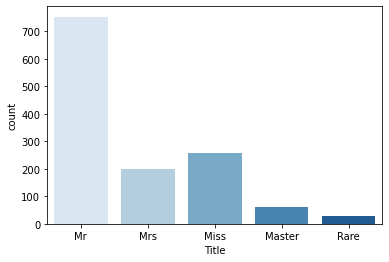

In [286]:
sns.countplot(combine['Title'], palette = "Blues")

In [288]:
# Mean of survival by name title

combine[['Title', 'Survived']].groupby(['Title'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.711111
0,Master,0.589744
4,Rare,0.347826
2,Mr,0.157895


Text(0.5, 1.0, 'Mean of survival by Title')

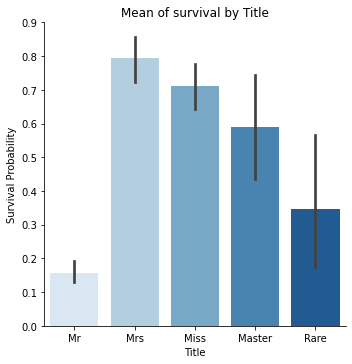

In [289]:
sns.catplot(x = 'Title', y = 'Survived', data = combine, kind = 'bar', palette = "Blues")
plt.ylabel('Survival Probability')
plt.title('Mean of survival by Title')

In [290]:
# Drop name column

combine = combine.drop('Name', axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0.0,3,0,22.0,1,0,1.981001,0,S,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,1,C,Mrs
2,3,1.0,3,1,26.0,0,0,2.070022,0,S,Miss
3,4,1.0,1,1,35.0,1,0,3.972177,1,S,Mrs
4,5,0.0,3,0,35.0,0,0,2.085672,0,S,Mr


## 5.3.2 isAlone

In [291]:
# Calculate family size from SibSp and Parch

combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [292]:
# Mean of survival by family size

combine[['FamilySize', 'Survived']].groupby('FamilySize', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,NaN


In [293]:
# Create IsAlone feature

combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1

In [294]:
# Mean of survival by IsAlone

combine[['IsAlone', 'Survived']].groupby('IsAlone', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [295]:
# Drop SibSp, Parch and FamilySize features from combine dataframe

combine = combine.drop(['SibSp', 'Parch', 'FamilySize'], axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,IsAlone
0,1,0.0,3,0,22.0,1.981001,0,S,Mr,0
1,2,1.0,1,1,38.0,4.266662,1,C,Mrs,0
2,3,1.0,3,1,26.0,2.070022,0,S,Miss,1
3,4,1.0,1,1,35.0,3.972177,1,S,Mrs,0
4,5,0.0,3,0,35.0,2.085672,0,S,Mr,1


## 5.3.3 Age*Class

In [296]:
# Create age bands and compute mean of survival by age bands

combine['AgeBand'] = pd.cut(combine['Age'], 5)
combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by = 'AgeBand')

,AgeBand,Survived
0,"(0.0902, 16.136]",0.532110
1,"(16.136, 32.102]",0.339662
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [297]:
# Assign ordinals to each age band 

combine.loc[combine['Age'] <= 16.136, 'Age'] = 0
combine.loc[(combine['Age'] > 16.136) & (combine['Age'] <= 32.102), 'Age'] = 1
combine.loc[(combine['Age'] > 32.102) & (combine['Age'] <= 48.068), 'Age'] = 2
combine.loc[(combine['Age'] > 48.068) & (combine['Age'] <= 64.034), 'Age'] = 3
combine.loc[combine['Age'] > 64.034 , 'Age'] = 4

In [298]:
# Drop age band feature

combine = combine.drop('AgeBand', axis = 1)

In [299]:
# Age and Pclass data types 

combine[['Age', 'Pclass', 'Cabin']].dtypes

Age       float64
Pclass      int64
Cabin      object
dtype: object

In [300]:
# Convert ordinal Age into integer

combine['Age'] = combine['Age'].astype('int')
combine['Age'].dtype

dtype('int64')

In [301]:
# Convert object Cabin into integer

combine['Cabin'] = combine['Cabin'].astype('int')
combine['Cabin'].dtype

dtype('int64')

In [302]:
# Create Age*Class feature

combine['Age*Class'] = combine['Age'] * combine['Pclass']
combine[['Age', 'Pclass', 'Age*Class']].head()

,Age,Pclass,Age*Class
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


## 5.4 Feature Encoding

In [304]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,IsAlone,Age*Class
0,1,0.0,3,0,1,1.981001,0,S,Mr,0,3
1,2,1.0,1,1,2,4.266662,1,C,Mrs,0,2
2,3,1.0,3,1,1,2.070022,0,S,Miss,1,3
3,4,1.0,1,1,2,3.972177,1,S,Mrs,0,2
4,5,0.0,3,0,2,2.085672,0,S,Mr,1,6


In [305]:
# Encode Title and Embarked feature

combine = pd.get_dummies(combine, columns = ['Title'])
combine = pd.get_dummies(combine, columns = ['Embarked'], prefix = 'Em')
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1.981001,0,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,4.266662,1,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,2.070022,0,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,3.972177,1,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,2.085672,0,1,6,0,0,1,0,0,0,0,1


In [306]:
# Divide Fare into four bands

combine['FareBand'] = pd.cut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.517007
3,"(4.679, 6.239]",0.750000


In [307]:
# Assign ordinal to each fare band

combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [308]:
# Convert Fare into integer

combine['Fare'] = combine['Fare'].astype('int')

In [309]:
# Drop FareBand feature

combine = combine.drop('FareBand', axis = 1)

In [310]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,2,1,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,1,0,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,2,1,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,1,0,1,6,0,0,1,0,0,0,0,1


In [311]:
# Separate training and test set from the combined dataframe

train = combine[:len(train)]
test = combine[len(train):]

In [312]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,2,1,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,1,0,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,2,1,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,1,0,1,6,0,0,1,0,0,0,0,1


In [313]:
# Drop passenger ID column from and training set

train = train.drop('PassengerId', axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0.0,3,0,1,1,0,0,3,0,0,1,0,0,0,0,1
1,1.0,1,1,2,2,1,0,2,0,0,0,1,0,1,0,0
2,1.0,3,1,1,1,0,1,3,0,1,0,0,0,0,0,1
3,1.0,1,1,2,2,1,0,2,0,0,0,1,0,0,0,1
4,0.0,3,0,2,1,0,1,6,0,0,1,0,0,0,0,1


In [314]:
# Convert survived back to integer in the training set

train['Survived'] = train['Survived'].astype('int')
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0,3,0,1,1,0,0,3,0,0,1,0,0,0,0,1
1,1,1,1,2,2,1,0,2,0,0,0,1,0,1,0,0
2,1,3,1,1,1,0,1,3,0,1,0,0,0,0,0,1
3,1,1,1,2,2,1,0,2,0,0,0,1,0,0,0,1
4,0,3,0,2,1,0,1,6,0,0,1,0,0,0,0,1


In [315]:
test.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,892,NaN,3,0,2,1,0,1,6,0,0,1,0,0,0,1,0
882,893,NaN,3,1,2,1,0,0,6,0,0,0,1,0,0,0,1
883,894,NaN,2,0,3,1,0,1,6,0,0,1,0,0,0,1,0
884,895,NaN,3,0,1,1,0,1,3,0,0,1,0,0,0,0,1
885,896,NaN,3,1,1,1,0,0,3,0,0,0,1,0,0,0,1


In [316]:
# Drop passenger survived column from test set

test = test.drop('Survived', axis = 1)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,892,3,0,2,1,0,1,6,0,0,1,0,0,0,1,0
882,893,3,1,2,1,0,0,6,0,0,0,1,0,0,0,1
883,894,2,0,3,1,0,1,6,0,0,1,0,0,0,1,0
884,895,3,0,1,1,0,1,3,0,0,1,0,0,0,0,1
885,896,3,1,1,1,0,0,3,0,0,0,1,0,0,0,1


## 6. Modeling<a name="6"></a>

## 6.1 Split training data

In [318]:
X_train = train.drop('Survived', axis = 1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis = 1).copy()
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (881, 15)
Y_train shape:  (881,)
X_test shape:  (418, 15)


## 6.2.1 Logistic Regression

In [320]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_logreg = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

83.09

## 6.2.2 Support Vector Machine

In [321]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred_svc = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.2

## 6.2.3 K Neighbors Classifier

In [322]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.9

## 6.2.4 Gaussian NB

In [323]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_gaussian = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.11

## 6.2.5 Perceptron

In [324]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred_perceptron = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

80.02

## 6.2.6 Linear Support Vector Machine

In [325]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred_linear_svc = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

80.82

## 6.2.7 Stochastic Gradient Descent 

In [326]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred_sgd = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

76.39

## 6.2.8 Decision Tree

In [327]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_predz_decision_tree = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.38

## 6.2.9 Random Forest

In [328]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred_random_forest = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.38

## 6.2.10 CatBoost

In [348]:
catboost = CatBoostClassifier()
catboost.fit(X_train, Y_train)
Y_pred_catboost = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

Learning rate set to 0.00976
0:	learn: 0.6858616	total: 4.41ms	remaining: 4.41s
1:	learn: 0.6795625	total: 4.94ms	remaining: 2.47s
2:	learn: 0.6732683	total: 5.48ms	remaining: 1.82s
3:	learn: 0.6677503	total: 6.04ms	remaining: 1.5s
4:	learn: 0.6617237	total: 6.45ms	remaining: 1.28s
5:	learn: 0.6559882	total: 6.98ms	remaining: 1.16s
6:	learn: 0.6501729	total: 8.2ms	remaining: 1.16s
7:	learn: 0.6439870	total: 8.6ms	remaining: 1.07s
8:	learn: 0.6407072	total: 8.85ms	remaining: 975ms
9:	learn: 0.6359114	total: 9.26ms	remaining: 916ms
10:	learn: 0.6310800	total: 9.57ms	remaining: 860ms
11:	learn: 0.6262068	total: 10.1ms	remaining: 829ms
12:	learn: 0.6210243	total: 10.4ms	remaining: 791ms
13:	learn: 0.6159225	total: 10.8ms	remaining: 759ms
14:	learn: 0.6105346	total: 11.3ms	remaining: 741ms
15:	learn: 0.6054657	total: 11.8ms	remaining: 725ms
16:	learn: 0.6010815	total: 12.2ms	remaining: 706ms
17:	learn: 0.5960039	total: 12.6ms	remaining: 688ms
18:	learn: 0.5912390	total: 13ms	remaining: 671m

364:	learn: 0.3592064	total: 178ms	remaining: 309ms
365:	learn: 0.3591359	total: 178ms	remaining: 309ms
366:	learn: 0.3590006	total: 179ms	remaining: 308ms
367:	learn: 0.3589851	total: 179ms	remaining: 308ms
368:	learn: 0.3588687	total: 180ms	remaining: 307ms
369:	learn: 0.3588533	total: 180ms	remaining: 307ms
370:	learn: 0.3587236	total: 180ms	remaining: 306ms
371:	learn: 0.3586265	total: 181ms	remaining: 306ms
372:	learn: 0.3585658	total: 182ms	remaining: 305ms
373:	learn: 0.3584632	total: 182ms	remaining: 305ms
374:	learn: 0.3584511	total: 183ms	remaining: 304ms
375:	learn: 0.3584067	total: 183ms	remaining: 304ms
376:	learn: 0.3583236	total: 183ms	remaining: 303ms
377:	learn: 0.3581946	total: 184ms	remaining: 303ms
378:	learn: 0.3580252	total: 184ms	remaining: 302ms
379:	learn: 0.3580013	total: 185ms	remaining: 301ms
380:	learn: 0.3579692	total: 185ms	remaining: 301ms
381:	learn: 0.3578839	total: 186ms	remaining: 300ms
382:	learn: 0.3577732	total: 186ms	remaining: 300ms
383:	learn: 

694:	learn: 0.3392693	total: 362ms	remaining: 159ms
695:	learn: 0.3392054	total: 362ms	remaining: 158ms
696:	learn: 0.3391773	total: 363ms	remaining: 158ms
697:	learn: 0.3391421	total: 363ms	remaining: 157ms
698:	learn: 0.3391038	total: 364ms	remaining: 157ms
699:	learn: 0.3390588	total: 364ms	remaining: 156ms
700:	learn: 0.3390220	total: 365ms	remaining: 156ms
701:	learn: 0.3389741	total: 365ms	remaining: 155ms
702:	learn: 0.3389151	total: 366ms	remaining: 155ms
703:	learn: 0.3388883	total: 366ms	remaining: 154ms
704:	learn: 0.3388552	total: 367ms	remaining: 153ms
705:	learn: 0.3387744	total: 367ms	remaining: 153ms
706:	learn: 0.3387381	total: 368ms	remaining: 153ms
707:	learn: 0.3386226	total: 369ms	remaining: 152ms
708:	learn: 0.3385679	total: 369ms	remaining: 152ms
709:	learn: 0.3385304	total: 370ms	remaining: 151ms
710:	learn: 0.3384913	total: 370ms	remaining: 151ms
711:	learn: 0.3384328	total: 371ms	remaining: 150ms
712:	learn: 0.3384214	total: 372ms	remaining: 150ms
713:	learn: 

In [349]:
acc_catboost

85.93

## 6.3 Model Evaluation and Hyperparameter Tuning

## 6.3.1 Training Accuracy

In [331]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

,Model,Score
0,Random Forest,86.38
1,Decision Tree,86.38
2,CatBoost,85.93
3,KNN,84.90
4,Support Vector Machines,83.20
5,Logistic Regression,83.09
6,Linear SVC,80.82
7,Perceptron,80.02
8,Naive Bayes,79.11
9,Stochastic Gradient Decent,76.39


## 6.3.2 K-fold Cross Validation

In [332]:
# Create a list which contains classifiers 

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [333]:
# Create a list which contains cross validation results for each classifier

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Learning rate set to 0.009326
0:	learn: 0.6860947	total: 760us	remaining: 759ms
1:	learn: 0.6800884	total: 1.38ms	remaining: 688ms
2:	learn: 0.6741180	total: 1.94ms	remaining: 645ms
3:	learn: 0.6687961	total: 2.52ms	remaining: 628ms
4:	learn: 0.6630703	total: 3.11ms	remaining: 618ms
5:	learn: 0.6567241	total: 3.54ms	remaining: 586ms
6:	learn: 0.6516186	total: 4.04ms	remaining: 574ms
7:	learn: 0.6455739	total: 4.56ms	remaining: 566ms
8:	learn: 0.6424370	total: 4.81ms	remaining: 530ms
9:	learn: 0.6379453	total: 5.31ms	remaining: 526ms
10:	learn: 0.6322013	total: 5.76ms	remaining: 518ms
11:	learn: 0.6278582	total: 6.12ms	remaining: 504ms
12:	learn: 0.6224113	total: 6.63ms	remaining: 504ms
13:	learn: 0.6174393	total: 7.07ms	remaining: 498ms
14:	learn: 0.6124604	total: 7.5ms	remaining: 492ms
15:	learn: 0.6072929	total: 7.86ms	remaining: 483ms
16:	learn: 0.6021861	total: 8.29ms	remaining: 479ms
17:	learn: 0.5977224	total: 8.81ms	remaining: 481ms
18:	learn: 0.5939774	total: 9.1ms	remaining: 4

392:	learn: 0.3532121	total: 183ms	remaining: 282ms
393:	learn: 0.3531450	total: 183ms	remaining: 282ms
394:	learn: 0.3531123	total: 184ms	remaining: 282ms
395:	learn: 0.3530955	total: 184ms	remaining: 281ms
396:	learn: 0.3529435	total: 185ms	remaining: 280ms
397:	learn: 0.3529009	total: 185ms	remaining: 280ms
398:	learn: 0.3528392	total: 185ms	remaining: 279ms
399:	learn: 0.3527871	total: 186ms	remaining: 279ms
400:	learn: 0.3527374	total: 186ms	remaining: 278ms
401:	learn: 0.3526517	total: 187ms	remaining: 278ms
402:	learn: 0.3525875	total: 187ms	remaining: 277ms
403:	learn: 0.3524594	total: 188ms	remaining: 277ms
404:	learn: 0.3524235	total: 188ms	remaining: 276ms
405:	learn: 0.3523708	total: 188ms	remaining: 276ms
406:	learn: 0.3523601	total: 189ms	remaining: 275ms
407:	learn: 0.3523145	total: 189ms	remaining: 275ms
408:	learn: 0.3522128	total: 190ms	remaining: 275ms
409:	learn: 0.3521127	total: 191ms	remaining: 274ms
410:	learn: 0.3520378	total: 191ms	remaining: 274ms
411:	learn: 

775:	learn: 0.3300553	total: 367ms	remaining: 106ms
776:	learn: 0.3300120	total: 368ms	remaining: 106ms
777:	learn: 0.3299394	total: 369ms	remaining: 105ms
778:	learn: 0.3299229	total: 369ms	remaining: 105ms
779:	learn: 0.3298702	total: 370ms	remaining: 104ms
780:	learn: 0.3298186	total: 370ms	remaining: 104ms
781:	learn: 0.3297478	total: 371ms	remaining: 103ms
782:	learn: 0.3297256	total: 371ms	remaining: 103ms
783:	learn: 0.3297059	total: 372ms	remaining: 102ms
784:	learn: 0.3296612	total: 372ms	remaining: 102ms
785:	learn: 0.3295788	total: 373ms	remaining: 101ms
786:	learn: 0.3295018	total: 373ms	remaining: 101ms
787:	learn: 0.3294476	total: 373ms	remaining: 100ms
788:	learn: 0.3294119	total: 374ms	remaining: 100ms
789:	learn: 0.3293276	total: 375ms	remaining: 99.6ms
790:	learn: 0.3292756	total: 375ms	remaining: 99.1ms
791:	learn: 0.3292196	total: 376ms	remaining: 98.6ms
792:	learn: 0.3291908	total: 376ms	remaining: 98.1ms
793:	learn: 0.3291491	total: 376ms	remaining: 97.6ms
794:	le

105:	learn: 0.4266754	total: 47.9ms	remaining: 404ms
106:	learn: 0.4257324	total: 48.5ms	remaining: 405ms
107:	learn: 0.4247362	total: 48.9ms	remaining: 404ms
108:	learn: 0.4240150	total: 49.5ms	remaining: 405ms
109:	learn: 0.4230209	total: 49.9ms	remaining: 404ms
110:	learn: 0.4222418	total: 50.3ms	remaining: 403ms
111:	learn: 0.4217626	total: 50.6ms	remaining: 401ms
112:	learn: 0.4214294	total: 50.8ms	remaining: 399ms
113:	learn: 0.4209534	total: 51.3ms	remaining: 398ms
114:	learn: 0.4201456	total: 51.9ms	remaining: 400ms
115:	learn: 0.4196541	total: 52.4ms	remaining: 400ms
116:	learn: 0.4190326	total: 52.9ms	remaining: 399ms
117:	learn: 0.4183556	total: 53.3ms	remaining: 398ms
118:	learn: 0.4178163	total: 53.7ms	remaining: 398ms
119:	learn: 0.4172116	total: 54.1ms	remaining: 397ms
120:	learn: 0.4165181	total: 54.5ms	remaining: 396ms
121:	learn: 0.4157642	total: 55ms	remaining: 396ms
122:	learn: 0.4151291	total: 55.7ms	remaining: 397ms
123:	learn: 0.4146901	total: 56ms	remaining: 396

498:	learn: 0.3484747	total: 233ms	remaining: 234ms
499:	learn: 0.3483719	total: 233ms	remaining: 233ms
500:	learn: 0.3482833	total: 234ms	remaining: 233ms
501:	learn: 0.3482154	total: 234ms	remaining: 233ms
502:	learn: 0.3481413	total: 235ms	remaining: 232ms
503:	learn: 0.3480737	total: 235ms	remaining: 231ms
504:	learn: 0.3479589	total: 236ms	remaining: 231ms
505:	learn: 0.3479011	total: 236ms	remaining: 231ms
506:	learn: 0.3478271	total: 237ms	remaining: 230ms
507:	learn: 0.3477062	total: 237ms	remaining: 230ms
508:	learn: 0.3477056	total: 237ms	remaining: 229ms
509:	learn: 0.3476448	total: 238ms	remaining: 228ms
510:	learn: 0.3475450	total: 238ms	remaining: 228ms
511:	learn: 0.3474699	total: 239ms	remaining: 228ms
512:	learn: 0.3473992	total: 240ms	remaining: 227ms
513:	learn: 0.3473215	total: 240ms	remaining: 227ms
514:	learn: 0.3472676	total: 241ms	remaining: 227ms
515:	learn: 0.3472017	total: 241ms	remaining: 226ms
516:	learn: 0.3471701	total: 241ms	remaining: 226ms
517:	learn: 

888:	learn: 0.3274646	total: 419ms	remaining: 52.3ms
889:	learn: 0.3274103	total: 419ms	remaining: 51.8ms
890:	learn: 0.3273546	total: 420ms	remaining: 51.4ms
891:	learn: 0.3273174	total: 420ms	remaining: 50.9ms
892:	learn: 0.3272596	total: 421ms	remaining: 50.4ms
893:	learn: 0.3271912	total: 421ms	remaining: 50ms
894:	learn: 0.3271464	total: 422ms	remaining: 49.5ms
895:	learn: 0.3270894	total: 422ms	remaining: 49ms
896:	learn: 0.3270563	total: 423ms	remaining: 48.6ms
897:	learn: 0.3269931	total: 423ms	remaining: 48.1ms
898:	learn: 0.3269554	total: 424ms	remaining: 47.6ms
899:	learn: 0.3269063	total: 424ms	remaining: 47.1ms
900:	learn: 0.3268781	total: 425ms	remaining: 46.7ms
901:	learn: 0.3268401	total: 425ms	remaining: 46.2ms
902:	learn: 0.3267947	total: 426ms	remaining: 45.7ms
903:	learn: 0.3267462	total: 426ms	remaining: 45.3ms
904:	learn: 0.3266955	total: 427ms	remaining: 44.8ms
905:	learn: 0.3266623	total: 427ms	remaining: 44.3ms
906:	learn: 0.3266244	total: 428ms	remaining: 43.9

247:	learn: 0.3490318	total: 118ms	remaining: 358ms
248:	learn: 0.3488116	total: 119ms	remaining: 359ms
249:	learn: 0.3488017	total: 119ms	remaining: 357ms
250:	learn: 0.3487515	total: 120ms	remaining: 358ms
251:	learn: 0.3484405	total: 121ms	remaining: 358ms
252:	learn: 0.3482192	total: 121ms	remaining: 357ms
253:	learn: 0.3480664	total: 121ms	remaining: 357ms
254:	learn: 0.3478874	total: 122ms	remaining: 356ms
255:	learn: 0.3476763	total: 122ms	remaining: 355ms
256:	learn: 0.3475420	total: 123ms	remaining: 355ms
257:	learn: 0.3473593	total: 123ms	remaining: 354ms
258:	learn: 0.3471392	total: 124ms	remaining: 354ms
259:	learn: 0.3470193	total: 124ms	remaining: 353ms
260:	learn: 0.3469853	total: 124ms	remaining: 352ms
261:	learn: 0.3467154	total: 125ms	remaining: 352ms
262:	learn: 0.3464868	total: 125ms	remaining: 352ms
263:	learn: 0.3462714	total: 126ms	remaining: 351ms
264:	learn: 0.3460872	total: 127ms	remaining: 351ms
265:	learn: 0.3459726	total: 127ms	remaining: 350ms
266:	learn: 

622:	learn: 0.3172028	total: 302ms	remaining: 183ms
623:	learn: 0.3171445	total: 303ms	remaining: 183ms
624:	learn: 0.3170855	total: 304ms	remaining: 182ms
625:	learn: 0.3169634	total: 304ms	remaining: 182ms
626:	learn: 0.3168919	total: 305ms	remaining: 181ms
627:	learn: 0.3168489	total: 305ms	remaining: 181ms
628:	learn: 0.3168469	total: 305ms	remaining: 180ms
629:	learn: 0.3167866	total: 306ms	remaining: 180ms
630:	learn: 0.3167370	total: 306ms	remaining: 179ms
631:	learn: 0.3167349	total: 306ms	remaining: 178ms
632:	learn: 0.3167017	total: 307ms	remaining: 178ms
633:	learn: 0.3166895	total: 307ms	remaining: 177ms
634:	learn: 0.3166149	total: 308ms	remaining: 177ms
635:	learn: 0.3166127	total: 308ms	remaining: 176ms
636:	learn: 0.3165659	total: 309ms	remaining: 176ms
637:	learn: 0.3164340	total: 309ms	remaining: 175ms
638:	learn: 0.3163870	total: 310ms	remaining: 175ms
639:	learn: 0.3163184	total: 310ms	remaining: 174ms
640:	learn: 0.3162045	total: 311ms	remaining: 174ms
641:	learn: 

992:	learn: 0.2996628	total: 483ms	remaining: 3.4ms
993:	learn: 0.2996230	total: 484ms	remaining: 2.92ms
994:	learn: 0.2995707	total: 484ms	remaining: 2.43ms
995:	learn: 0.2995428	total: 485ms	remaining: 1.95ms
996:	learn: 0.2995118	total: 485ms	remaining: 1.46ms
997:	learn: 0.2994802	total: 485ms	remaining: 972us
998:	learn: 0.2994570	total: 486ms	remaining: 486us
999:	learn: 0.2994418	total: 486ms	remaining: 0us
Learning rate set to 0.009331
0:	learn: 0.6860118	total: 531us	remaining: 531ms
1:	learn: 0.6801279	total: 1.13ms	remaining: 563ms
2:	learn: 0.6736753	total: 1.62ms	remaining: 538ms
3:	learn: 0.6687124	total: 2.09ms	remaining: 520ms
4:	learn: 0.6630643	total: 2.56ms	remaining: 510ms
5:	learn: 0.6575618	total: 3.04ms	remaining: 503ms
6:	learn: 0.6521412	total: 3.54ms	remaining: 502ms
7:	learn: 0.6462064	total: 3.9ms	remaining: 483ms
8:	learn: 0.6432555	total: 4.14ms	remaining: 456ms
9:	learn: 0.6382216	total: 4.48ms	remaining: 444ms
10:	learn: 0.6325192	total: 4.83ms	remaining

364:	learn: 0.3602653	total: 172ms	remaining: 299ms
365:	learn: 0.3601027	total: 172ms	remaining: 299ms
366:	learn: 0.3600447	total: 173ms	remaining: 298ms
367:	learn: 0.3600321	total: 173ms	remaining: 298ms
368:	learn: 0.3599004	total: 174ms	remaining: 297ms
369:	learn: 0.3598328	total: 174ms	remaining: 297ms
370:	learn: 0.3597456	total: 175ms	remaining: 296ms
371:	learn: 0.3596646	total: 175ms	remaining: 296ms
372:	learn: 0.3595881	total: 176ms	remaining: 295ms
373:	learn: 0.3595375	total: 176ms	remaining: 295ms
374:	learn: 0.3594429	total: 176ms	remaining: 294ms
375:	learn: 0.3592830	total: 177ms	remaining: 294ms
376:	learn: 0.3591954	total: 177ms	remaining: 293ms
377:	learn: 0.3590323	total: 178ms	remaining: 292ms
378:	learn: 0.3589657	total: 178ms	remaining: 292ms
379:	learn: 0.3588682	total: 179ms	remaining: 292ms
380:	learn: 0.3587691	total: 179ms	remaining: 292ms
381:	learn: 0.3587049	total: 180ms	remaining: 291ms
382:	learn: 0.3585816	total: 180ms	remaining: 291ms
383:	learn: 

751:	learn: 0.3360525	total: 357ms	remaining: 118ms
752:	learn: 0.3360152	total: 357ms	remaining: 117ms
753:	learn: 0.3359826	total: 358ms	remaining: 117ms
754:	learn: 0.3359022	total: 358ms	remaining: 116ms
755:	learn: 0.3358219	total: 359ms	remaining: 116ms
756:	learn: 0.3358127	total: 359ms	remaining: 115ms
757:	learn: 0.3357869	total: 359ms	remaining: 115ms
758:	learn: 0.3357402	total: 360ms	remaining: 114ms
759:	learn: 0.3356880	total: 361ms	remaining: 114ms
760:	learn: 0.3356079	total: 361ms	remaining: 113ms
761:	learn: 0.3355729	total: 362ms	remaining: 113ms
762:	learn: 0.3355130	total: 362ms	remaining: 113ms
763:	learn: 0.3354738	total: 363ms	remaining: 112ms
764:	learn: 0.3354129	total: 363ms	remaining: 112ms
765:	learn: 0.3353978	total: 364ms	remaining: 111ms
766:	learn: 0.3353121	total: 364ms	remaining: 111ms
767:	learn: 0.3352528	total: 365ms	remaining: 110ms
768:	learn: 0.3352302	total: 365ms	remaining: 110ms
769:	learn: 0.3351468	total: 365ms	remaining: 109ms
770:	learn: 

123:	learn: 0.4170855	total: 56.5ms	remaining: 399ms
124:	learn: 0.4165353	total: 57.2ms	remaining: 400ms
125:	learn: 0.4159184	total: 57.6ms	remaining: 400ms
126:	learn: 0.4151655	total: 58.2ms	remaining: 400ms
127:	learn: 0.4148980	total: 58.5ms	remaining: 398ms
128:	learn: 0.4142799	total: 59.1ms	remaining: 399ms
129:	learn: 0.4139316	total: 59.5ms	remaining: 398ms
130:	learn: 0.4131331	total: 59.9ms	remaining: 397ms
131:	learn: 0.4124953	total: 60.4ms	remaining: 397ms
132:	learn: 0.4118311	total: 60.8ms	remaining: 397ms
133:	learn: 0.4113473	total: 61.2ms	remaining: 396ms
134:	learn: 0.4111577	total: 61.5ms	remaining: 394ms
135:	learn: 0.4106236	total: 61.9ms	remaining: 393ms
136:	learn: 0.4101728	total: 62.5ms	remaining: 393ms
137:	learn: 0.4096863	total: 62.9ms	remaining: 393ms
138:	learn: 0.4090082	total: 63.3ms	remaining: 392ms
139:	learn: 0.4083027	total: 63.9ms	remaining: 392ms
140:	learn: 0.4080224	total: 64.3ms	remaining: 392ms
141:	learn: 0.4076263	total: 64.7ms	remaining:

510:	learn: 0.3518076	total: 241ms	remaining: 231ms
511:	learn: 0.3516828	total: 241ms	remaining: 230ms
512:	learn: 0.3516362	total: 242ms	remaining: 230ms
513:	learn: 0.3515510	total: 242ms	remaining: 229ms
514:	learn: 0.3514525	total: 243ms	remaining: 229ms
515:	learn: 0.3513934	total: 243ms	remaining: 228ms
516:	learn: 0.3512921	total: 244ms	remaining: 228ms
517:	learn: 0.3512704	total: 244ms	remaining: 227ms
518:	learn: 0.3512316	total: 245ms	remaining: 227ms
519:	learn: 0.3511458	total: 245ms	remaining: 226ms
520:	learn: 0.3511393	total: 246ms	remaining: 226ms
521:	learn: 0.3510816	total: 246ms	remaining: 226ms
522:	learn: 0.3509177	total: 247ms	remaining: 225ms
523:	learn: 0.3508565	total: 247ms	remaining: 225ms
524:	learn: 0.3507748	total: 248ms	remaining: 224ms
525:	learn: 0.3507552	total: 248ms	remaining: 224ms
526:	learn: 0.3506286	total: 249ms	remaining: 223ms
527:	learn: 0.3505740	total: 249ms	remaining: 223ms
528:	learn: 0.3505422	total: 250ms	remaining: 222ms
529:	learn: 

897:	learn: 0.3307783	total: 425ms	remaining: 48.3ms
898:	learn: 0.3307116	total: 426ms	remaining: 47.8ms
899:	learn: 0.3306823	total: 426ms	remaining: 47.4ms
900:	learn: 0.3306382	total: 427ms	remaining: 46.9ms
901:	learn: 0.3305750	total: 427ms	remaining: 46.4ms
902:	learn: 0.3305051	total: 428ms	remaining: 45.9ms
903:	learn: 0.3304470	total: 428ms	remaining: 45.5ms
904:	learn: 0.3304055	total: 429ms	remaining: 45ms
905:	learn: 0.3303540	total: 429ms	remaining: 44.5ms
906:	learn: 0.3302957	total: 430ms	remaining: 44.1ms
907:	learn: 0.3302325	total: 430ms	remaining: 43.6ms
908:	learn: 0.3301927	total: 431ms	remaining: 43.1ms
909:	learn: 0.3301214	total: 432ms	remaining: 42.7ms
910:	learn: 0.3300633	total: 432ms	remaining: 42.2ms
911:	learn: 0.3300082	total: 433ms	remaining: 41.8ms
912:	learn: 0.3299120	total: 434ms	remaining: 41.3ms
913:	learn: 0.3298817	total: 434ms	remaining: 40.8ms
914:	learn: 0.3298359	total: 434ms	remaining: 40.4ms
915:	learn: 0.3297936	total: 435ms	remaining: 39

255:	learn: 0.3698239	total: 124ms	remaining: 359ms
256:	learn: 0.3697810	total: 124ms	remaining: 359ms
257:	learn: 0.3695311	total: 124ms	remaining: 358ms
258:	learn: 0.3693515	total: 125ms	remaining: 358ms
259:	learn: 0.3690547	total: 125ms	remaining: 357ms
260:	learn: 0.3688558	total: 126ms	remaining: 356ms
261:	learn: 0.3687149	total: 126ms	remaining: 356ms
262:	learn: 0.3685732	total: 127ms	remaining: 355ms
263:	learn: 0.3684418	total: 127ms	remaining: 354ms
264:	learn: 0.3683334	total: 128ms	remaining: 354ms
265:	learn: 0.3681875	total: 129ms	remaining: 355ms
266:	learn: 0.3679749	total: 129ms	remaining: 355ms
267:	learn: 0.3678297	total: 130ms	remaining: 354ms
268:	learn: 0.3677089	total: 130ms	remaining: 353ms
269:	learn: 0.3676356	total: 130ms	remaining: 353ms
270:	learn: 0.3674404	total: 131ms	remaining: 353ms
271:	learn: 0.3673169	total: 132ms	remaining: 352ms
272:	learn: 0.3671556	total: 132ms	remaining: 352ms
273:	learn: 0.3669892	total: 133ms	remaining: 352ms
274:	learn: 

649:	learn: 0.3411932	total: 307ms	remaining: 165ms
650:	learn: 0.3411444	total: 308ms	remaining: 165ms
651:	learn: 0.3411309	total: 308ms	remaining: 165ms
652:	learn: 0.3410156	total: 309ms	remaining: 164ms
653:	learn: 0.3409755	total: 309ms	remaining: 164ms
654:	learn: 0.3409140	total: 310ms	remaining: 163ms
655:	learn: 0.3408818	total: 310ms	remaining: 163ms
656:	learn: 0.3408312	total: 311ms	remaining: 162ms
657:	learn: 0.3407822	total: 312ms	remaining: 162ms
658:	learn: 0.3407650	total: 312ms	remaining: 161ms
659:	learn: 0.3407261	total: 313ms	remaining: 161ms
660:	learn: 0.3406724	total: 313ms	remaining: 160ms
661:	learn: 0.3406410	total: 313ms	remaining: 160ms
662:	learn: 0.3406396	total: 314ms	remaining: 159ms
663:	learn: 0.3405849	total: 314ms	remaining: 159ms
664:	learn: 0.3405678	total: 315ms	remaining: 159ms
665:	learn: 0.3405141	total: 315ms	remaining: 158ms
666:	learn: 0.3404791	total: 316ms	remaining: 158ms
667:	learn: 0.3404407	total: 316ms	remaining: 157ms
668:	learn: 

10:	learn: 0.6322822	total: 5ms	remaining: 450ms
11:	learn: 0.6277096	total: 5.46ms	remaining: 449ms
12:	learn: 0.6231354	total: 5.77ms	remaining: 438ms
13:	learn: 0.6189714	total: 6.17ms	remaining: 435ms
14:	learn: 0.6140544	total: 6.72ms	remaining: 441ms
15:	learn: 0.6088429	total: 7.15ms	remaining: 440ms
16:	learn: 0.6038788	total: 7.58ms	remaining: 438ms
17:	learn: 0.5989712	total: 8.12ms	remaining: 443ms
18:	learn: 0.5954536	total: 8.55ms	remaining: 442ms
19:	learn: 0.5915363	total: 9ms	remaining: 441ms
20:	learn: 0.5877937	total: 9.67ms	remaining: 451ms
21:	learn: 0.5835970	total: 10.1ms	remaining: 448ms
22:	learn: 0.5789933	total: 10.6ms	remaining: 452ms
23:	learn: 0.5748002	total: 11.1ms	remaining: 453ms
24:	learn: 0.5710787	total: 11.6ms	remaining: 452ms
25:	learn: 0.5671047	total: 12.2ms	remaining: 457ms
26:	learn: 0.5644527	total: 12.5ms	remaining: 451ms
27:	learn: 0.5612254	total: 13.1ms	remaining: 455ms
28:	learn: 0.5580848	total: 13.4ms	remaining: 450ms
29:	learn: 0.55490

379:	learn: 0.3544472	total: 188ms	remaining: 307ms
380:	learn: 0.3543199	total: 189ms	remaining: 306ms
381:	learn: 0.3543002	total: 189ms	remaining: 306ms
382:	learn: 0.3542469	total: 189ms	remaining: 305ms
383:	learn: 0.3542292	total: 190ms	remaining: 305ms
384:	learn: 0.3541214	total: 190ms	remaining: 304ms
385:	learn: 0.3539302	total: 191ms	remaining: 304ms
386:	learn: 0.3538422	total: 192ms	remaining: 304ms
387:	learn: 0.3537686	total: 192ms	remaining: 303ms
388:	learn: 0.3536981	total: 193ms	remaining: 303ms
389:	learn: 0.3535498	total: 193ms	remaining: 302ms
390:	learn: 0.3534145	total: 194ms	remaining: 302ms
391:	learn: 0.3533014	total: 194ms	remaining: 301ms
392:	learn: 0.3532151	total: 195ms	remaining: 301ms
393:	learn: 0.3531024	total: 196ms	remaining: 301ms
394:	learn: 0.3529491	total: 196ms	remaining: 300ms
395:	learn: 0.3528794	total: 196ms	remaining: 300ms
396:	learn: 0.3528126	total: 197ms	remaining: 300ms
397:	learn: 0.3527187	total: 198ms	remaining: 299ms
398:	learn: 

754:	learn: 0.3307613	total: 371ms	remaining: 120ms
755:	learn: 0.3307234	total: 372ms	remaining: 120ms
756:	learn: 0.3306794	total: 372ms	remaining: 119ms
757:	learn: 0.3306453	total: 373ms	remaining: 119ms
758:	learn: 0.3305315	total: 373ms	remaining: 118ms
759:	learn: 0.3304993	total: 374ms	remaining: 118ms
760:	learn: 0.3304728	total: 374ms	remaining: 117ms
761:	learn: 0.3303829	total: 375ms	remaining: 117ms
762:	learn: 0.3303204	total: 375ms	remaining: 117ms
763:	learn: 0.3303124	total: 376ms	remaining: 116ms
764:	learn: 0.3302341	total: 376ms	remaining: 116ms
765:	learn: 0.3301917	total: 377ms	remaining: 115ms
766:	learn: 0.3301105	total: 377ms	remaining: 115ms
767:	learn: 0.3300776	total: 378ms	remaining: 114ms
768:	learn: 0.3300107	total: 378ms	remaining: 114ms
769:	learn: 0.3299184	total: 379ms	remaining: 113ms
770:	learn: 0.3298887	total: 379ms	remaining: 113ms
771:	learn: 0.3298759	total: 380ms	remaining: 112ms
772:	learn: 0.3297320	total: 380ms	remaining: 112ms
773:	learn: 

120:	learn: 0.4115165	total: 57.2ms	remaining: 415ms
121:	learn: 0.4108773	total: 57.9ms	remaining: 417ms
122:	learn: 0.4102205	total: 58.4ms	remaining: 416ms
123:	learn: 0.4097062	total: 59ms	remaining: 417ms
124:	learn: 0.4093695	total: 59.2ms	remaining: 415ms
125:	learn: 0.4088206	total: 59.8ms	remaining: 415ms
126:	learn: 0.4081199	total: 60.2ms	remaining: 414ms
127:	learn: 0.4074952	total: 60.7ms	remaining: 414ms
128:	learn: 0.4069456	total: 61.1ms	remaining: 413ms
129:	learn: 0.4063536	total: 61.6ms	remaining: 412ms
130:	learn: 0.4057643	total: 62ms	remaining: 411ms
131:	learn: 0.4052856	total: 62.5ms	remaining: 411ms
132:	learn: 0.4047213	total: 62.9ms	remaining: 410ms
133:	learn: 0.4042380	total: 63.3ms	remaining: 409ms
134:	learn: 0.4036921	total: 63.8ms	remaining: 408ms
135:	learn: 0.4032832	total: 64.1ms	remaining: 407ms
136:	learn: 0.4027446	total: 64.6ms	remaining: 407ms
137:	learn: 0.4021775	total: 65.2ms	remaining: 407ms
138:	learn: 0.4015922	total: 65.6ms	remaining: 406

496:	learn: 0.3476343	total: 240ms	remaining: 243ms
497:	learn: 0.3476123	total: 241ms	remaining: 242ms
498:	learn: 0.3475734	total: 241ms	remaining: 242ms
499:	learn: 0.3475018	total: 242ms	remaining: 242ms
500:	learn: 0.3474697	total: 242ms	remaining: 241ms
501:	learn: 0.3474161	total: 242ms	remaining: 240ms
502:	learn: 0.3473457	total: 243ms	remaining: 240ms
503:	learn: 0.3472477	total: 243ms	remaining: 240ms
504:	learn: 0.3471946	total: 244ms	remaining: 239ms
505:	learn: 0.3471427	total: 244ms	remaining: 239ms
506:	learn: 0.3470391	total: 245ms	remaining: 238ms
507:	learn: 0.3469754	total: 245ms	remaining: 238ms
508:	learn: 0.3469327	total: 246ms	remaining: 237ms
509:	learn: 0.3468734	total: 247ms	remaining: 237ms
510:	learn: 0.3468253	total: 247ms	remaining: 237ms
511:	learn: 0.3467926	total: 248ms	remaining: 236ms
512:	learn: 0.3467118	total: 248ms	remaining: 236ms
513:	learn: 0.3466395	total: 249ms	remaining: 235ms
514:	learn: 0.3465860	total: 249ms	remaining: 235ms
515:	learn: 

877:	learn: 0.3286071	total: 426ms	remaining: 59.1ms
878:	learn: 0.3285780	total: 426ms	remaining: 58.7ms
879:	learn: 0.3285389	total: 427ms	remaining: 58.2ms
880:	learn: 0.3284542	total: 427ms	remaining: 57.7ms
881:	learn: 0.3283971	total: 428ms	remaining: 57.2ms
882:	learn: 0.3283291	total: 428ms	remaining: 56.7ms
883:	learn: 0.3282955	total: 429ms	remaining: 56.3ms
884:	learn: 0.3282497	total: 429ms	remaining: 55.8ms
885:	learn: 0.3282053	total: 430ms	remaining: 55.3ms
886:	learn: 0.3281729	total: 430ms	remaining: 54.8ms
887:	learn: 0.3281096	total: 431ms	remaining: 54.3ms
888:	learn: 0.3280748	total: 434ms	remaining: 54.1ms
889:	learn: 0.3280479	total: 434ms	remaining: 53.6ms
890:	learn: 0.3279891	total: 435ms	remaining: 53.2ms
891:	learn: 0.3279480	total: 435ms	remaining: 52.7ms
892:	learn: 0.3279118	total: 435ms	remaining: 52.2ms
893:	learn: 0.3278692	total: 436ms	remaining: 51.7ms
894:	learn: 0.3278385	total: 436ms	remaining: 51.2ms
895:	learn: 0.3277842	total: 437ms	remaining: 

233:	learn: 0.3851783	total: 111ms	remaining: 363ms
234:	learn: 0.3850761	total: 112ms	remaining: 363ms
235:	learn: 0.3848513	total: 112ms	remaining: 362ms
236:	learn: 0.3846363	total: 112ms	remaining: 362ms
237:	learn: 0.3844352	total: 113ms	remaining: 361ms
238:	learn: 0.3842289	total: 113ms	remaining: 360ms
239:	learn: 0.3840376	total: 113ms	remaining: 359ms
240:	learn: 0.3838014	total: 114ms	remaining: 360ms
241:	learn: 0.3835311	total: 115ms	remaining: 360ms
242:	learn: 0.3833199	total: 115ms	remaining: 360ms
243:	learn: 0.3831407	total: 116ms	remaining: 359ms
244:	learn: 0.3829368	total: 116ms	remaining: 359ms
245:	learn: 0.3827753	total: 117ms	remaining: 358ms
246:	learn: 0.3826374	total: 117ms	remaining: 358ms
247:	learn: 0.3824335	total: 118ms	remaining: 358ms
248:	learn: 0.3823122	total: 118ms	remaining: 357ms
249:	learn: 0.3820972	total: 119ms	remaining: 357ms
250:	learn: 0.3818274	total: 119ms	remaining: 356ms
251:	learn: 0.3815164	total: 120ms	remaining: 356ms
252:	learn: 

627:	learn: 0.3497977	total: 294ms	remaining: 174ms
628:	learn: 0.3497496	total: 295ms	remaining: 174ms
629:	learn: 0.3497133	total: 295ms	remaining: 174ms
630:	learn: 0.3496848	total: 296ms	remaining: 173ms
631:	learn: 0.3496345	total: 296ms	remaining: 173ms
632:	learn: 0.3496145	total: 297ms	remaining: 172ms
633:	learn: 0.3495492	total: 297ms	remaining: 172ms
634:	learn: 0.3494811	total: 298ms	remaining: 171ms
635:	learn: 0.3494808	total: 298ms	remaining: 170ms
636:	learn: 0.3494416	total: 298ms	remaining: 170ms
637:	learn: 0.3494077	total: 299ms	remaining: 170ms
638:	learn: 0.3493385	total: 299ms	remaining: 169ms
639:	learn: 0.3492895	total: 300ms	remaining: 169ms
640:	learn: 0.3492528	total: 300ms	remaining: 168ms
641:	learn: 0.3491981	total: 301ms	remaining: 168ms
642:	learn: 0.3491633	total: 301ms	remaining: 167ms
643:	learn: 0.3491129	total: 301ms	remaining: 167ms
644:	learn: 0.3490302	total: 302ms	remaining: 166ms
645:	learn: 0.3489697	total: 302ms	remaining: 166ms
646:	learn: 

0:	learn: 0.6863181	total: 579us	remaining: 579ms
1:	learn: 0.6803918	total: 1.14ms	remaining: 570ms
2:	learn: 0.6744160	total: 1.66ms	remaining: 551ms
3:	learn: 0.6693288	total: 2.04ms	remaining: 508ms
4:	learn: 0.6636385	total: 2.39ms	remaining: 475ms
5:	learn: 0.6581363	total: 2.75ms	remaining: 456ms
6:	learn: 0.6526102	total: 3.13ms	remaining: 444ms
7:	learn: 0.6467793	total: 3.53ms	remaining: 438ms
8:	learn: 0.6435595	total: 3.76ms	remaining: 414ms
9:	learn: 0.6390300	total: 4.23ms	remaining: 419ms
10:	learn: 0.6344411	total: 4.48ms	remaining: 403ms
11:	learn: 0.6288225	total: 4.84ms	remaining: 399ms
12:	learn: 0.6248073	total: 5.23ms	remaining: 397ms
13:	learn: 0.6196923	total: 5.58ms	remaining: 393ms
14:	learn: 0.6145473	total: 5.97ms	remaining: 392ms
15:	learn: 0.6102406	total: 6.32ms	remaining: 389ms
16:	learn: 0.6056433	total: 6.68ms	remaining: 386ms
17:	learn: 0.6013936	total: 7.03ms	remaining: 383ms
18:	learn: 0.5971369	total: 7.4ms	remaining: 382ms
19:	learn: 0.5925232	tot

394:	learn: 0.3604661	total: 186ms	remaining: 284ms
395:	learn: 0.3604526	total: 186ms	remaining: 284ms
396:	learn: 0.3603293	total: 186ms	remaining: 283ms
397:	learn: 0.3602941	total: 187ms	remaining: 283ms
398:	learn: 0.3602023	total: 187ms	remaining: 282ms
399:	learn: 0.3601343	total: 188ms	remaining: 281ms
400:	learn: 0.3600259	total: 188ms	remaining: 281ms
401:	learn: 0.3600120	total: 189ms	remaining: 281ms
402:	learn: 0.3599864	total: 189ms	remaining: 280ms
403:	learn: 0.3599487	total: 189ms	remaining: 279ms
404:	learn: 0.3598947	total: 190ms	remaining: 279ms
405:	learn: 0.3598268	total: 190ms	remaining: 278ms
406:	learn: 0.3598082	total: 190ms	remaining: 278ms
407:	learn: 0.3597088	total: 191ms	remaining: 277ms
408:	learn: 0.3596777	total: 191ms	remaining: 276ms
409:	learn: 0.3595899	total: 192ms	remaining: 276ms
410:	learn: 0.3594745	total: 193ms	remaining: 276ms
411:	learn: 0.3593793	total: 193ms	remaining: 276ms
412:	learn: 0.3592513	total: 194ms	remaining: 276ms
413:	learn: 

779:	learn: 0.3368645	total: 372ms	remaining: 105ms
780:	learn: 0.3368278	total: 372ms	remaining: 104ms
781:	learn: 0.3367811	total: 372ms	remaining: 104ms
782:	learn: 0.3367294	total: 373ms	remaining: 103ms
783:	learn: 0.3366972	total: 373ms	remaining: 103ms
784:	learn: 0.3366780	total: 374ms	remaining: 102ms
785:	learn: 0.3366337	total: 375ms	remaining: 102ms
786:	learn: 0.3365660	total: 375ms	remaining: 101ms
787:	learn: 0.3365536	total: 375ms	remaining: 101ms
788:	learn: 0.3365167	total: 376ms	remaining: 101ms
789:	learn: 0.3365011	total: 376ms	remaining: 100ms
790:	learn: 0.3364527	total: 377ms	remaining: 99.6ms
791:	learn: 0.3364244	total: 377ms	remaining: 99.1ms
792:	learn: 0.3363995	total: 378ms	remaining: 98.6ms
793:	learn: 0.3363638	total: 378ms	remaining: 98.2ms
794:	learn: 0.3363074	total: 379ms	remaining: 97.7ms
795:	learn: 0.3362623	total: 379ms	remaining: 97.2ms
796:	learn: 0.3361915	total: 380ms	remaining: 96.7ms
797:	learn: 0.3361391	total: 380ms	remaining: 96.2ms
798:

In [334]:
# Mean and standard deviation of cross validation results for each classifier  

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [336]:
cv_res = pd.DataFrame({'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost'], 'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Algorithm,Cross Validation Mean,Cross Validation Std
0,Support Vector Machines,0.824042,0.043568
1,CatBoost,0.812743,0.029952
2,Random Forest,0.807074,0.033843
3,KNN,0.807061,0.039559
4,Logistic Regression,0.805899,0.033895
5,Linear SVC,0.803652,0.031207
6,Gausian Naive Bayes,0.783210,0.034940
7,Decision Tree,0.778716,0.035234
8,Stochastic Gradient Descent,0.758223,0.049047
9,Perceptron,0.738866,0.109000


Text(0.5, 1.0, 'Cross Validation Scores')

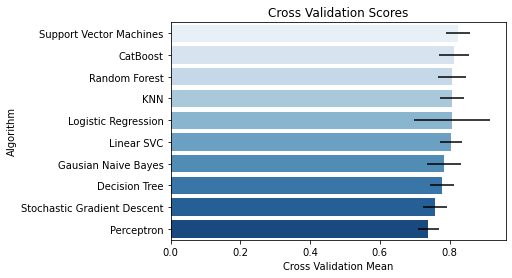

In [337]:
sns.barplot('Cross Validation Mean', 'Algorithm', data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Blues', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')

## 6.3.3 Hyperparameter Tuning for SVM

In [338]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.734 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.682 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.705 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.693 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.814 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.767 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.712 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.830 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.774 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.767 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.778 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.825 total time=   0.1s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.1s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.784 total time=   0.1s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.875 total time=   0.0s
[CV 1/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [339]:
print("Best parameters: ", grid.best_params_) 
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator:  SVC(C=100, gamma=0.01)


In [340]:
# Training accuracy

svc = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.65

In [341]:
# Mean cross validation score

cross_val_score(svc, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0.831996935648621

In [362]:
# Survival predictions by support vector classifier

Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [363]:
len(Y_pred)

418

In [350]:
Y_pred_catboost

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [365]:
new_pred = np.mean(np.array([Y_pred, Y_pred_catboost, Y_pred_random_forest]), axis=0)
new_pred

array([0.        , 0.33333333, 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       1.        , 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.33333333, 0.        , 0.66666667,
       0.        , 0.33333333, 0.33333333, 0.        , 0.66666667,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.33333333,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 0.33333333, 1.        ,
       1.        , 0.        , 0.33333333, 0.33333333, 1.     

In [366]:
new_pred.round()

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [369]:
new_pred = new_pred.astype(int)

## 7. Preparing for Submission<a name="7"></a>

In [370]:
# Create submission dataframe

submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': new_pred})
submit.head()

,PassengerId,Survived
881,892,0
882,893,0
883,894,0
884,895,0
885,896,1


In [371]:
submit.shape

(418, 2)

In [372]:
submit.to_csv("submission1.csv", index=False)

In [373]:
!kaggle competitions submit -c titanic -f ./submission1.csv -m "Submission with SVM"

100%|██████████████████████████████████████| 2.77k/2.77k [00:01<00:00, 1.87kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster